# 算法选型
Temporal Fusion Transformer（TFT）是专为时间序列预测设计的深度学习模型,论文《Temporal Fusion Transformers for Interpretable Multi-horizon Time Series Forecasting》
1. 融合 Transformer 自注意力机制与时间序列特异性模块，能高效捕捉长序列依赖和多变量间关系；
2. 支持静态 / 动态特征、多目标 / 概率预测，且可解释性强；
3. 广泛应用于需求预测、金融、能源等领域，是多变量时序预测的主流方案之一。

# PyTorch Forecastin库  
1. PyTorch Forecasting 是一个基于 PyTorch 的时间序列预测库，旨在简化时间序列预测任务。它提供了丰富的功能和工具  
2. 广泛的应用领域：PyTorch Forecasting 在多个领域得到广泛应用，包括计算机视觉、自然语言处理、推荐系统等  
3. 时间序列数据的处理：该库提供了时间序列数据集类，抽象了变量转换、缺失值处理等复杂性，使得数据准备更加简便。


# 实现目标
1. 支持自定义股票数据训练  
可指定任意股票历史数据文件，训练该股票的时序预测模型。
可指定股票数据的时间段  
3. 数据自动处理与特征工程  
自动读取原始股票数据，完成缺失值处理、特征扩展（如对数成交量、波动率等），并生成模型所需的时间序列特征。
4. 基于 Temporal Fusion Transformer 进行多变量时序预测  
使用 TFT 模型，融合多种静态和动态特征，提升对股票收盘价的预测能力。
5. 训练过程自动保存模型权重与归一化器  
自动保存训练好的模型权重和归一化器，便于后续预测和复现。
6. 支持指定日期的未来收盘价预测  
可指定任意日期，模型自动预测该日期之后若干天（如 6 天）的收盘价，并输出预测结果。
7. 可视化预测结果变化曲线  
自动绘制未来收盘价预测变化曲线，便于直观分析股票走势。

# 1、导入相关的python库

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
from typing import Optional
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import joblib
import pytorch_lightning as pl
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline
from pytorch_forecasting.data import GroupNormalizer, NaNLabelEncoder
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from lightning.pytorch.tuner import Tuner
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from pytorch_lightning.loggers import CSVLogger

# 训练的库
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import CSVLogger
import lightning.pytorch as pl
from pytorch_forecasting import TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss

# 2、读取历史股票数据

In [3]:
def read_csv_to_df(filepath='data.csv', encoding='utf-8', **kwargs):
    """
    全读取 CSV 并返回 pandas.DataFrame。
    """
    try:
        df = pd.read_csv(filepath, encoding=encoding, **kwargs)
        return df
    except Exception as e:
        print(f"读取 CSV 出错: {e}")
        raise

In [4]:
def read_csv_to_df_rang(
    filepath='data.csv',
    start_time=None,
    end_time=None,
    date_col='date',
    encoding='utf-8',
    **kwargs
):
    """
    带日期：读取CSV并按指定日期范围筛选数据
    """
    try:
        # 1. 读取完整CSV
        df = pd.read_csv(filepath, encoding=encoding, **kwargs)
        
        # 2. 将日期列转为datetime格式（确保能按日期筛选）
        df[date_col] = pd.to_datetime(df[date_col])
        
        # 3. 按日期范围筛选
        if start_time is not None:
            start_time = pd.to_datetime(start_time)
            df = df[df[date_col] >= start_time]
        
        if end_time is not None:
            end_time = pd.to_datetime(end_time)
            df = df[df[date_col] <= end_time]
        
        return df
    
    except Exception as e:
        print(f"读取或筛选CSV出错: {e}")
        raise

# 3、展示数据

In [5]:
filepath = '../data/day_k_datash.600000.csv'
df = read_csv_to_df_rang(filepath, start_time="2025-01-01", end_time="2025-02-01")
# 查看数据
df.head(10)

,date,code,open,high,low,close,preclose,volume,amount,adjustflag,turn,tradestatus,pctChg,isST,peTTM,psTTM,pcfNcfTTM,pbMRQ


字段说明：  
| 序号 | 参数名称 | 参数描述 | 算法说明 |
|-----|---------|---------|---------|
| 1 | date | 交易所行情日期 | |
| 2 | code | 证券代码 | |
| 3 | open | 开盘价 | |
| 4 | high | 最高价 | |
| 5 | low | 最低价 | |
| 6 | close | 收盘价 | |
| 7 | preclose | 前收盘价 | 见表格下方详细说明 |
| 8 | volume | 成交量（累计 单位：股） | |
| 9 | amount | 成交额（单位：人民币元） | |
| 10 | adjustflag | 复权状态 | 1：后复权，2：前复权，3：不复权 |
| 11 | turn | 换手率 | [指定交易日的成交量(股)/指定交易日的股票的流通股总股数(股)]*100% |
| 12 | tradestatus | 交易状态 | 1：正常交易 0：停牌 |
| 13 | pctChg | 涨跌幅（百分比） | 日涨跌幅=[(指定交易日的收盘价-指定交易日前收盘价)/指定交易日前收盘价]*100% |
| 14 | isST | 是否ST股 | 1是，0否 |

# 4、模型训练
## 4.1 数据处理（增加新的股票字段、并处理缺失值）

In [6]:
def data_process(filename,start_time,end_time):
    """
    读取数据，增加新字段，并处理缺失值
    """
    df = read_csv_to_df_rang(filepath, start_time=start_time, end_time=end_time)

    # 添加时间索引，由0开始，为连续的整数
    df["date"] = pd.to_datetime(df["date"])
    df["time_idx"] = df["date"].rank(method="dense").astype(int) - 1\
    
    # 获取时间的月份、周几
    df["month"] = df["date"].dt.month.astype(str)
    df["dayofweek"] = df["date"].dt.dayofweek.astype(str)
    df["adjustflag"] = df["adjustflag"].astype(str)

    # 拓展字段
    df["log_volume"] = np.log1p(df["volume"])  # 成交量对数变换
    df["high_low_ratio"] = (df["high"] - df["low"]) / df["close"]  # 日内波动幅度比
    df["amount_per_share"] = df["amount"] / df["volume"]  # 每股成交额
    df["price_range"] = df["high"] - df["low"]  # 日内价格波动范围
    
    df["isST"] = df["isST"].astype(str)  # 转为字符串

    df = df[df["tradestatus"] == 1].copy()   # 过滤停牌
    # 填充可能的缺失值
    df.fillna({
        "volume": 0,
        "amount": 0,
        "turn": 0,
        "pctChg": 0
    }, inplace=True)
    
    return df

## 4.2 获取最新的训练权重

In [7]:
def get_latest_tft_ckpt_path(
    root_dir: str = r".\training_logs\tft_stock_prediction",
    checkpoint_dir_name: str = "checkpoints",
    ckpt_file_suffix: str = ".ckpt"
) -> Optional[str]:
    """
    自动查找最新的TFT模型ckpt文件路径（按version_x递增取最大）
    
    Args:
        root_dir: 固定根路径（不变部分），默认：.\training_logs\tft_stock_prediction
        checkpoint_dir_name: checkpoints目录名称（固定），默认：checkpoints
        ckpt_file_suffix: ckpt文件后缀（固定），默认：.ckpt
    
    Returns:
        最新ckpt文件的完整路径；如果未找到则返回None
    """
    # 1. 验证根路径是否存在
    if not os.path.exists(root_dir):
        print(f"错误：根路径不存在 -> {root_dir}")
        return None
    
    # 2. 遍历根路径下的所有子目录，筛选出 "version_x" 格式的目录
    version_dirs = []
    for dir_name in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, dir_name)
        if os.path.isdir(dir_path) and dir_name.startswith("version_"):
            try:
                version_num = int(dir_name.split("_")[-1])
                version_dirs.append((version_num, dir_path))
            except (ValueError, IndexError):
                continue
    
    # 3. 没有找到任何version目录
    if not version_dirs:
        print(f"错误：在根路径下未找到 version_x 格式的目录 -> {root_dir}")
        return None
    
    # 4. 按version数字降序排序，取最大的那个（最新版本）
    version_dirs.sort(reverse=True, key=lambda x: x[0])
    latest_version_num, latest_version_path = version_dirs[0]
    
    # 5. 拼接checkpoints目录路径
    checkpoint_dir = os.path.join(latest_version_path, checkpoint_dir_name)
    if not os.path.exists(checkpoint_dir):
        return None
    
    # 6. 查找checkpoints目录下的ckpt文件
    ckpt_files = [f for f in os.listdir(checkpoint_dir) if f.endswith(ckpt_file_suffix)]
    if not ckpt_files:
        return None
    
    ckpt_files_with_mtime = [
        (os.path.join(checkpoint_dir, f), os.path.getmtime(os.path.join(checkpoint_dir, f)))
        for f in ckpt_files
    ]
    # 按文件修改时间降序排序，取最新的
    ckpt_files_with_mtime.sort(reverse=True, key=lambda x: x[1])
    latest_ckpt_path, latest_mtime = ckpt_files_with_mtime[0]

    return latest_ckpt_path

## 4.3 定义训练函数

In [8]:
def training(filename, start_time, end_time):
    """
    模型训练
    """
    # 1、读取数据
    df = data_process(filename, start_time=start_time, end_time=end_time)

    # 2、定义划分的参数
    max_encoder_length = 24  # 用24天历史数据
    max_prediction_length = 6  # 预测未来6天
    training_cutoff = df["time_idx"].max() - max_prediction_length  # 训练截止点
    
    # 3、 构建训练集
    training = TimeSeriesDataSet(
        df[lambda x: x.time_idx <= training_cutoff],
        time_idx="time_idx",
        target="close",  # 预测目标-收盘价
        group_ids=["code"],
        min_encoder_length=max_encoder_length // 2,
        max_encoder_length=max_encoder_length,
        min_prediction_length=1,
        max_prediction_length=max_prediction_length,
        static_categoricals=["code", "isST"],   # 不变
        static_reals=[],
        time_varying_known_categoricals=["month", "dayofweek", "adjustflag"],   # T+1已知特征
        time_varying_known_reals=[
            "time_idx", "preclose", 
            "pctChg", "turn", "amount_per_share", "price_range" 
        ],
        time_varying_unknown_categoricals=[],    # T+1未知特征
        time_varying_unknown_reals=[
            "close", "open", "high", "low",
            "volume", "log_volume", "amount", "high_low_ratio" 
        ],
        
        target_normalizer=GroupNormalizer(
            groups=["code"], transformation="softplus"
        ),
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
        allow_missing_timesteps=True   # 允许时间不连续
    )
    
    # 4、构建验证集
    validation = TimeSeriesDataSet.from_dataset(training, df, predict=True, stop_randomization=True, allow_missing_timesteps=True)
    
    # 5、创建数据加载器
    batch_size = 16
    train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

    # 保存正则化后的训练器--用于预测
    joblib.dump(training.target_normalizer, "target_normalizer.pkl")


    pl.seed_everything(42)
    trainer = pl.Trainer(
        accelerator="cpu",
        gradient_clip_val=0.1,
    )

    # 6、定义回调函数和Logger
    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
    lr_logger = LearningRateMonitor()  # log the learning rate
    logger = CSVLogger("training_logs", name="tft_stock_prediction")
    
    # 7、创建Trainer
    trainer = pl.Trainer(
        max_epochs=20,
        accelerator="cpu",
        enable_model_summary=True,
        gradient_clip_val=0.1,
        limit_train_batches=50,  # comment in for training, running validation every 30 batches
        # fast_dev_run=True,  # comment in to check that network or dataset has no serious bugs
        callbacks=[lr_logger, early_stop_callback],
        logger=logger,
        default_root_dir="./tft_model_checkpoints",
        enable_checkpointing=True
    )
    
    # 8、创建TFT模型
    tft = TemporalFusionTransformer.from_dataset(
        training,
        learning_rate=0.03,  # 初始值会被下面的手动设置覆盖
        hidden_size=16,
        attention_head_size=2,
        dropout=0.1,
        hidden_continuous_size=8,
        loss=QuantileLoss(),
        log_interval=10,
        optimizer="Ranger",
        reduce_on_plateau_patience=4,
    )
    
    best_lr = 0.01 
    tft.hparams.learning_rate = best_lr
    tft.learning_rate = best_lr  # 双重保险，确保优化器使用新的学习率
    
    print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")
    print(f"Manually set learning rate: {best_lr}")
    
    # 9、开始训练（补充这一步，否则模型不会训练）
    trainer.fit(
        tft,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )
    print("training success!")

    # 获取权重路径
    latest_ckpt = get_latest_tft_ckpt_path()
    return latest_ckpt, val_dataloader

## 4.4 训练股票数据

**可通过“filename”替换成其他股票，训练预测模型**

In [38]:
# 训练股票，训练从2020-01-01到2025-09-15的数据
filename = "../data/day_k_datash.600000.csv"
checkpoint_path, val_dataloader = training(filename,start_time="2020-01-01", end_time="2025-09-15")
print(f'权重保存路径：{checkpoint_path}')

Seed set to 42
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbeddi

Number of parameters in network: 32.4k
Manually set learning rate: 0.01
Epoch 0: 100%|█████████████████████████████████████████| 50/50 [00:04<00:00, 12.36it/s, v_num=4, train_loss_step=0.582]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|█| 50/50 [00:03<00:00, 12.87it/s, v_num=4, train_loss_step=0.243, val_loss=3.460, train_loss_epoch=1.140]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|█| 50/50 [00:03<00:00, 12.65it/s, v_num=4, train_loss_step=0.156, val_loss=2.220, train_loss_epoch=0.556]
Validation: |                                                                           

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|█| 50/50 [00:04<00:00, 11.70it/s, v_num=4, train_loss_step=0.0278, val_loss=0.0676, train_loss_epoch=0.0
training success!
权重保存路径：.\training_logs\tft_stock_prediction\version_4\checkpoints\epoch=19-step=1000.ckpt


# 5、模型验证评估

In [39]:
# 评估：训练后validation越小越好
best_tft = TemporalFusionTransformer.load_from_checkpoint(checkpoint_path)
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
MAE()(predictions.output, predictions.y)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


tensor(0.1137)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


实际样本数量: 1


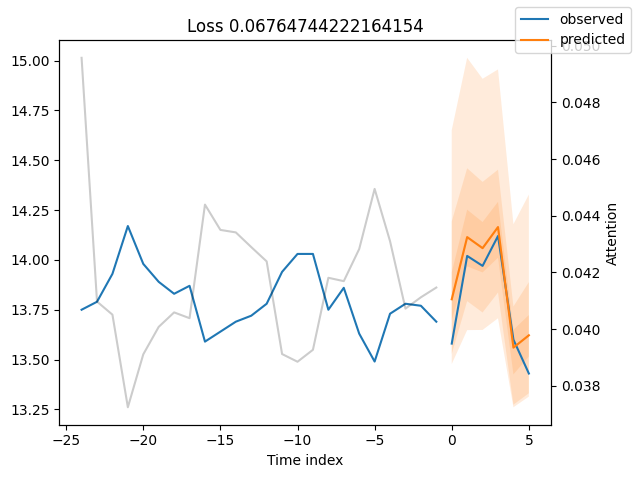

In [40]:
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)
num_samples = len(raw_predictions.x["encoder_cont"])  # 或检查其他key的长度
print(f"实际样本数量: {num_samples}")

# 根据实际数量绘制，最多画10个或全部样本
plot_num = min(10, num_samples)
for idx in range(plot_num):  
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

# 6、分析

-  TFT模型的训练方法是：用前24天的数据，预测后6天的数据
-  查看图表x轴0-5段，预测值和真实值曲线贴合，误差小